# Utils: Compute and plot free energy surface and free energy differences

Authors: Ioannis Galdadas & Luigi Bonati & Enrico Trizio

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/luigibonati/mlcolvar/blob/main/docs/notebooks/tutorials/utils_fes.ipynb)

In the following example we show how to use the function `compute_fes` from `mlcolvar.utils.fes` to calculate and visualize the free energy surface.

In [ ]:
# Colab setup
import os

if os.getenv("COLAB_RELEASE_TAG"):
    import subprocess
    subprocess.run('wget https://raw.githubusercontent.com/luigibonati/mlcolvar/main/colab_setup.sh', shell=True)
    cmd = subprocess.run('bash colab_setup.sh TUTORIAL', shell=True, stdout=subprocess.PIPE)
    print(cmd.stdout.decode('utf-8'))


from mlcolvar.utils.plot import paletteFessa
from mlcolvar.utils.io import load_dataframe
from mlcolvar.utils.fes import compute_fes, compute_deltaG
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np

# Load COLVAR file containing collective variables (and bias information)
colvar = load_dataframe('https://raw.githubusercontent.com/EnricoTrizio/TargetedDiscriminantAnalysisCVs/refs/heads/main/alanine/deepTDA_enhanced_sampling/colvar')


# In general, you should use the simulations parameters, for example:
temperature = 300 
kb = 0.0083144621       # Boltzmann constant in kJ/(mol·K)
kbt = kb * temperature 

Calculate statistical weights in case of a biased simulation (uncomment one of the options)

In [2]:
# (1) unbiased simulation
#bias = None

# (2) reweight for a single bias
bias = colvar['opes.bias'].values

# (3) reweight multiple bias potentials (e.g. OPES and harmonic walls)
#bias = colvar[['opes.bias','lwall.bias','uwall.bias']].sum(axis=1).values

# (4) reweight all field *.bias in the COLVAR
#bias = colvar.filter(regex='.bias').sum(axis=1).values

# calculate the weights
weights = np.exp( bias / kbt )

Calculate and plot 1d free energy surface. For the full list of options see the documentation. 

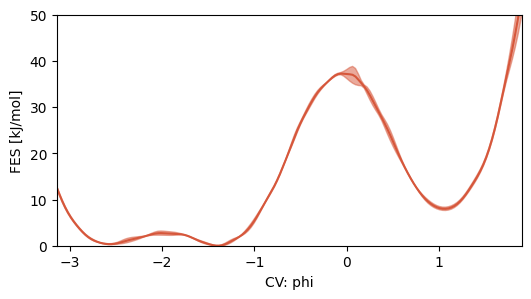

In [ ]:
cv_name = 'phi'
cv1d = colvar[cv_name].values

fes_params = {
    'blocks': 3,            # Number of blocks for error analysis
    'bandwidth': 0.012,     # Kernel bandwidth (sigma) for density estimation. if 'range', the bandwidth is expressed as ratio of the range of values (e.g. here it is 1% of it)
    'scale_by': 'range',    # Method to scale the bandwidth
    'temp' : temperature,   # temperature for proper energy scaling (alternative to kbt)
    'fes_units': 'kJ/mol',  # units of the free energy
    'weights': weights,     # Statistical weights from the bias  
}

fig, ax = plt.subplots(figsize=(6,3))
fes1D, grid1D, bounds1D, error1D = compute_fes(
    cv1d,
    plot=True,
    ax = ax,
    **fes_params
)

# make a nice plot
ax.set_xlabel(f'CV: {cv_name}')
ax.set_xlim(-np.pi, 1.9)
ax.set_ylim(0, 50)

plt.show()

2D free energy surface

/home/etrizio@iit.local/Bin/dev/mlcolvar/mlcolvar/utils/fes.py:235: RuntimeWarning: invalid value encountered in log
  * np.log(kde.evaluate(cartesian(pos)) + e)
/home/etrizio@iit.local/Bin/dev/mlcolvar/mlcolvar/utils/fes.py:235: RuntimeWarning: invalid value encountered in log
  * np.log(kde.evaluate(cartesian(pos)) + e)


Adjusting regularization (eps) to 1.0e-14 to avoid NaNs.


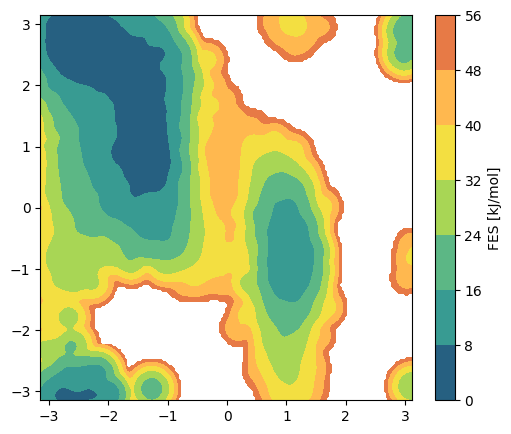

In [ ]:
cv2d = colvar[['phi', 'psi']].values

# or equivalently
# cv1 = colvar['phi'].values.squeeze()  
# cv2 = colvar['psi'].values.squeeze()
# cv2d = np.stack((cv1, cv2)).transpose()

fes_params = {
    'blocks': 1,            # Number of blocks for error analysis
    'bandwidth': 0.015,     # Kernel bandwidth (sigma) for density estimation
    'scale_by': 'range',    # Method to scale the bandwidth. 
    'temp': temperature,    # temperature for proper energy scaling (alternative to kbt)
    'fes_units': 'kJ/mol',  # units of the free energy
    'weights': weights,     # Statistical weights from the bias
}

fig, ax = plt.subplots(figsize=(6,5))
fes2, grid2, bounds2, error2 = compute_fes(
    cv2d,
    plot=True,
    plot_max_fes=55,
    ax=ax,
    **fes_params
)

Free energy difference: deltaG

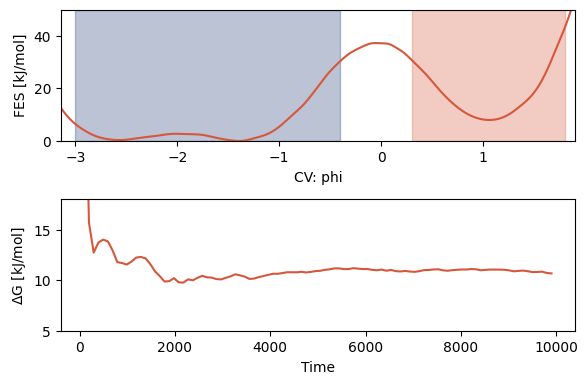

In [5]:
# set bounds to identify states
stateA_bounds = [-3.0, -0.4]
stateB_bounds = [0.3, 1.8]

fig, axs = plt.subplots(2, 1, figsize=(6, 4))

# plot fes for reference and check states bounds
ax = axs[0]
ax.plot(grid1D, fes1D, color='fessa6')

# highlight states over FES
for b, (xmin, xmax) in enumerate([stateA_bounds, stateB_bounds]):
    rect = patches.Rectangle((xmin, 0), xmax - xmin, 50 - 0, fill=True, color=f'fessa{b*6}', alpha=0.3)
    ax.add_patch(rect)

# add labels
ax.set_xlabel(f'CV: {cv_name}')
ax.set_ylabel(f'FES [{fes_params["fes_units"]}]')
ax.set_xlim(-np.pi, 1.9)
ax.set_ylim(0, 50)


# plot and compute deltaG
ax = axs[1]
blocks_1D, deltaG_1D = compute_deltaG(X=cv1d,
                                      stateA_bounds=stateA_bounds,
                                      stateB_bounds=stateB_bounds,
                                      temp=temperature,
                                      fes_units='kJ/mol',
                                      nblocks=100,
                                      weights=weights,
                                      time=colvar['time'].values,
                                      plot=True,
                                      ax=ax,
                                      )
ax.set_ylim(5, 18)

plt.tight_layout()
plt.show()

Adjusting regularization (eps) to 1.0e-14 to avoid NaNs.


/home/etrizio@iit.local/Bin/dev/mlcolvar/mlcolvar/utils/fes.py:235: RuntimeWarning: invalid value encountered in log
  * np.log(kde.evaluate(cartesian(pos)) + e)
/home/etrizio@iit.local/Bin/dev/mlcolvar/mlcolvar/utils/fes.py:235: RuntimeWarning: invalid value encountered in log
  * np.log(kde.evaluate(cartesian(pos)) + e)


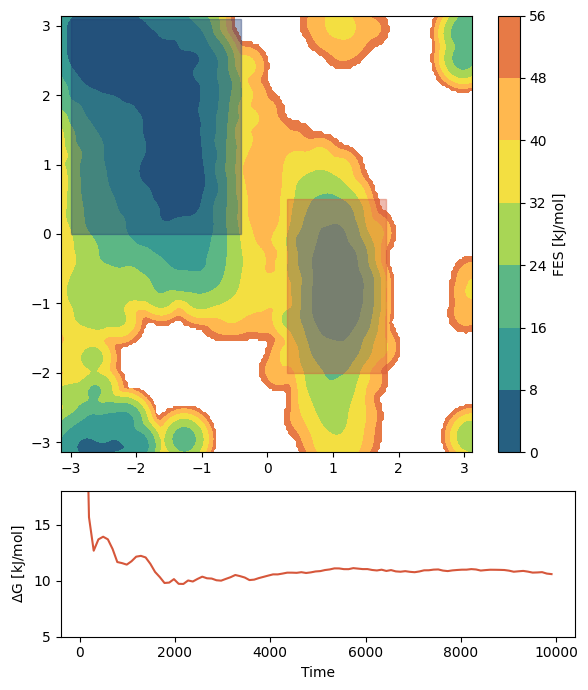

In [6]:
# set 2D bounds to identify states
stateA_bounds = [[-3.0, -0.4], [0, 3.1]]
stateB_bounds = [[0.3, 1.8], [-2, 0.5]]


fig, axs = plt.subplots(2, 1, figsize=(6,7), gridspec_kw={'height_ratios': [3,1]})
ax = axs[0]
# plot 2D FES
fes2, grid2, bounds2, error2 = compute_fes(
    cv2d,
    plot=True,
    plot_max_fes=55,
    ax=ax,
    **fes_params
)

# highlight states on FES
for b, ((xmin, xmax), (ymin, ymax)) in enumerate([stateA_bounds, stateB_bounds]):
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=True, color=f'fessa{b*6}', alpha=0.4)
    ax.add_patch(rect)

# compute deltaG on 2D data
ax = axs[1]
blocks_2D, deltaG_2D = compute_deltaG(X=cv2d,
                                      stateA_bounds=stateA_bounds,
                                      stateB_bounds=stateB_bounds,
                                      temp=temperature,
                                      fes_units='kJ/mol',
                                      nblocks=100,
                                      weights=weights,
                                      time=colvar['time'].values,
                                      plot=True,
                                      ax=ax
                                      )
ax.set_ylim(5, 18)
plt.tight_layout()
plt.show()

Compare 1D vs 2D

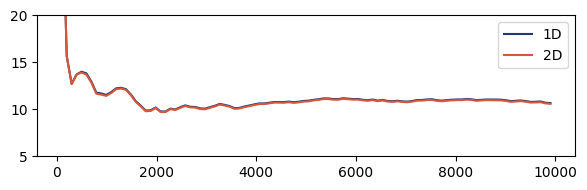

In [7]:
fig, ax = plt.subplots(figsize=(6,2))
ax.plot(blocks_1D, deltaG_1D, c='fessa0', label='1D')
ax.plot(blocks_2D, deltaG_2D, c='fessa6', label='2D')
plt.legend()
ax.set_ylim(5,20)

plt.tight_layout()
plt.show()